In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from os import getcwd
#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

#Check for GPU utilization
if tf.test.gpu_device_name():
    print(' GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")

TF version: 2.2.0
 GPU: /device:GPU:0


In [2]:
# define a callback

'''
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get('acc')>=0.95):
            print("\nReached 95% accuracy ")
            self.model.stop_training = True

callbacks = myCallback()
'''

callbacks = tf.keras.callbacks.EarlyStopping(monitor = 'acc', 
                                             patience = 10, 
                                             restore_best_weights = True)

In [3]:
# Define dirs and files
train_dir = '../data/training/'
validation_dir = '../data/validation/'

train_wash_dir = os.path.join(train_dir,'wash')
train_nowash_dir = os.path.join(train_dir,'nowash')
validation_wash_dir = os.path.join(validation_dir,'wash')
validation_nowash_dir = os.path.join(validation_dir,'nowash')

train_wash_fnames = os.listdir(train_wash_dir)
train_nowash_fnames = os.listdir(train_nowash_dir)
validation_wash_fnames = os.listdir(validation_wash_dir)
validation_nowash_fnames = os.listdir(validation_nowash_dir)


print(len(os.listdir(train_wash_dir)))
print(len(os.listdir(train_nowash_dir)))
print(len(os.listdir(validation_wash_dir)))
print(len(os.listdir(validation_nowash_dir)))

total_train=len(os.listdir(train_wash_dir))+ len(os.listdir(train_nowash_dir))
total_val=len(os.listdir(validation_wash_dir))+ len(os.listdir(validation_nowash_dir))

144
167
37
42


In [4]:
#build data generators for training and validaton

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator( rescale =1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# rescale val data
val_datagen = ImageDataGenerator( rescale =1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

#set batch Size
batch_size = 10

#set Image size
imsize = (400,400) 
imshape = (400,400,3)

# Flow training images in batches 
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = batch_size,
                                                    class_mode = 'binary',
                                                    target_size = imsize)

# Flow validation images in batches 
validation_generator =  val_datagen.flow_from_directory( validation_dir,
                                                         batch_size = batch_size,
                                                         class_mode = 'binary',
                                                         target_size = imsize)


Found 311 images belonging to 2 classes.
Found 79 images belonging to 2 classes.


In [5]:
# define the metrics
acc_metric = tf.keras.metrics.BinaryAccuracy(name='acc')

In [6]:
#base model, no top layer, w/ imagenet weights
base_model = tf.keras.applications.MobileNetV2(input_shape = imshape, 
                                             include_top=False, 
                                             weights='imagenet')

base_model.trainable = False
base_model.summary()


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 401, 401, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 200, 200, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 200, 200, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [7]:
# add a new classifcation layer

final_layer = base_model.get_layer('out_relu')
print('shape of last layer is ', final_layer.output_shape)
final_base_output = final_layer.output


#add the last layer
# Flatten the output layer to 1 dimension
x = layers.Flatten()(final_base_output )
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)           

model = Model(base_model.input, x) 

model.summary()

shape of last layer is  (None, 13, 13, 1280)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 401, 401, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 200, 200, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 200, 200, 32) 128         Conv1[0][0]                      
_________________________________________________

In [8]:
#build the model

from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=acc_metric)

In [9]:
#train the model
history = model.fit(train_generator,
                              steps_per_epoch = total_train // batch_size,
                              validation_data = validation_generator,
                              epochs= 100,
                              validation_steps =  total_val // batch_size,
                              callbacks =[callbacks])

Epoch 1/100
31/31 [==============================] - 73s 2s/step - loss: 6.0649 - acc: 0.7581 - val_loss: 2.1360 - val_acc: 0.7714
Epoch 2/100
31/31 [==============================] - 74s 2s/step - loss: 3.5411 - acc: 0.8239 - val_loss: 2.7666 - val_acc: 0.8714
Epoch 3/100
31/31 [==============================] - 72s 2s/step - loss: 2.7058 - acc: 0.8571 - val_loss: 2.7096 - val_acc: 0.8429
Epoch 4/100
31/31 [==============================] - 73s 2s/step - loss: 2.6147 - acc: 0.8206 - val_loss: 1.9977 - val_acc: 0.8571
Epoch 5/100
31/31 [==============================] - 72s 2s/step - loss: 2.0959 - acc: 0.8704 - val_loss: 2.3108 - val_acc: 0.8143
Epoch 6/100
31/31 [==============================] - 73s 2s/step - loss: 2.4363 - acc: 0.8439 - val_loss: 1.8822 - val_acc: 0.8857
Epoch 7/100
31/31 [==============================] - 73s 2s/step - loss: 1.8304 - acc: 0.8605 - val_loss: 1.4472 - val_acc: 0.8143
Epoch 8/100
31/31 [==============================] - 75s 2s/step - loss: 1.4937 - a

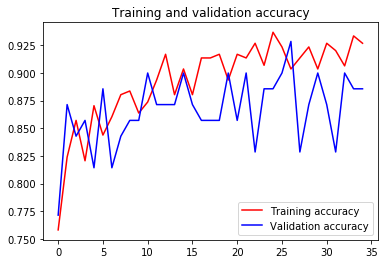

<Figure size 432x288 with 0 Axes>

In [10]:
#look at the metrics from training

%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [11]:
#save the model
fp='./saved_MobileNetV2'
tf.keras.models.save_model(model,fp)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./saved_MobileNetV2/assets


In [23]:
#test the model
import numpy as np

#define test directory
test_dir_wash = '../data/testing_michael/wash/'
test_dir_nowash = '../data/testing_michael/nowash'

#load images for wash
w_test = []
w_labels = []
for img in os.listdir(test_dir_wash):
    #pull the name of the image
    w_labels.append(img)
    #pull the image
    img = os.path.join(test_dir_wash, img)
    img = tf.keras.preprocessing.image.load_img(img,target_size=(400,400))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img/255
    img = np.expand_dims(img,axis=0)
    w_test.append(img)

#load images for nowash
nw_test = []
nw_labels = []
for img in os.listdir(test_dir_nowash):
    #pull the name of the image
    nw_labels.append(img)
    #pull the image
    img = os.path.join(test_dir_nowash, img)
    img = tf.keras.preprocessing.image.load_img(img,target_size=(400,400))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img/255
    img = np.expand_dims(img,axis=0)
    nw_test.append(img)


In [24]:
#make predictions 
w_test = np.vstack(w_test)
w_preds = model.predict(w_test)

nw_test = np.vstack(nw_test)
nw_preds = model.predict(nw_test)

In [48]:
#stack up the predicitons and truth in the same format

#vstack pred array
all_pred = np.vstack((nw_preds,w_preds))
all_pred = all_pred > 0.5

#vstack true array
all_true = np.vstack((np.full((70,1), False), np.full((70,1), True)))

In [49]:
#report relevant binary classification stats for test data
from sklearn import metrics

report = metrics.classification_report(all_true, all_pred)
print(report)

              precision    recall  f1-score   support

       False       0.90      0.80      0.85        70
        True       0.82      0.91      0.86        70

    accuracy                           0.86       140
   macro avg       0.86      0.86      0.86       140
weighted avg       0.86      0.86      0.86       140



In [50]:
#and the confusion matrix for test data
metrics.confusion_matrix(all_true, all_pred)

array([[56, 14],
       [ 6, 64]])